Mounted at /content/drive
Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')


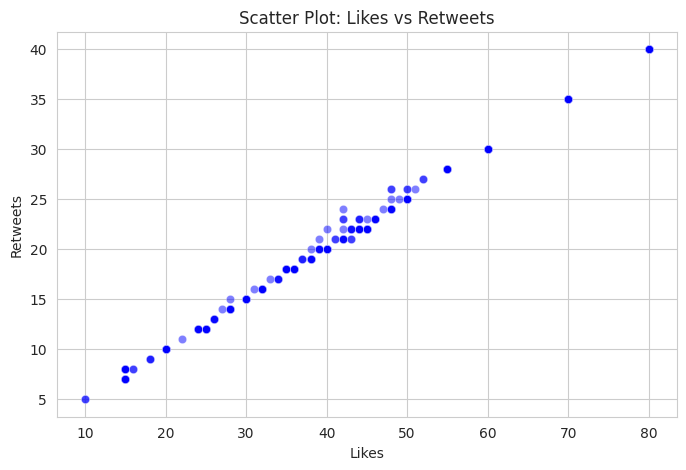

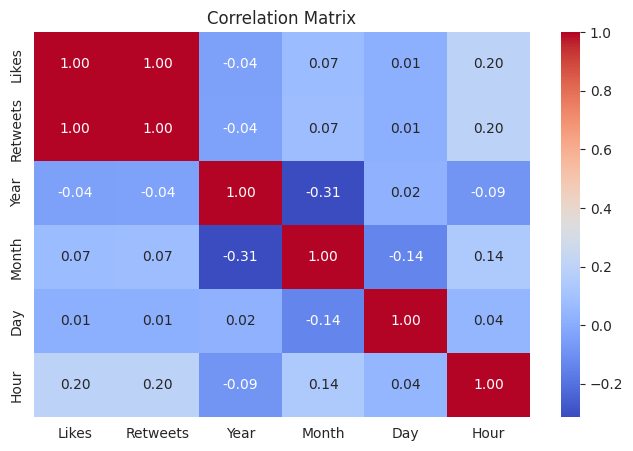

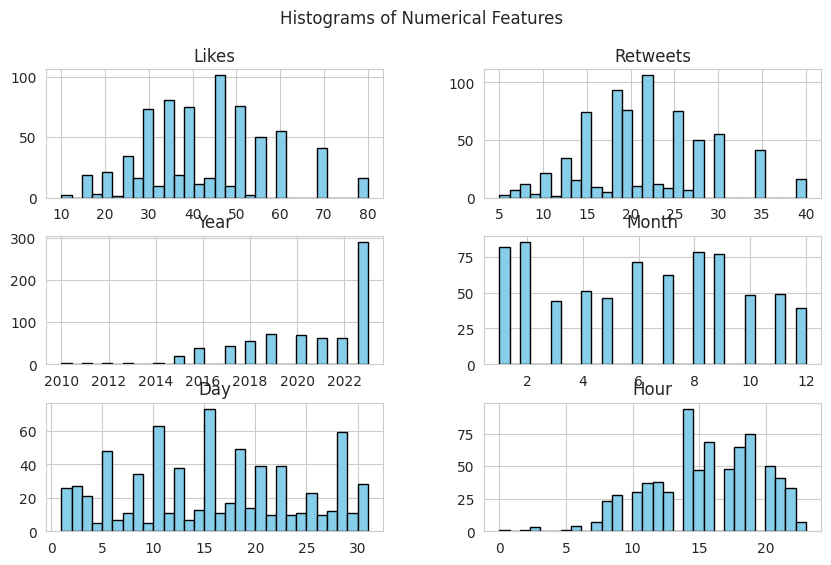

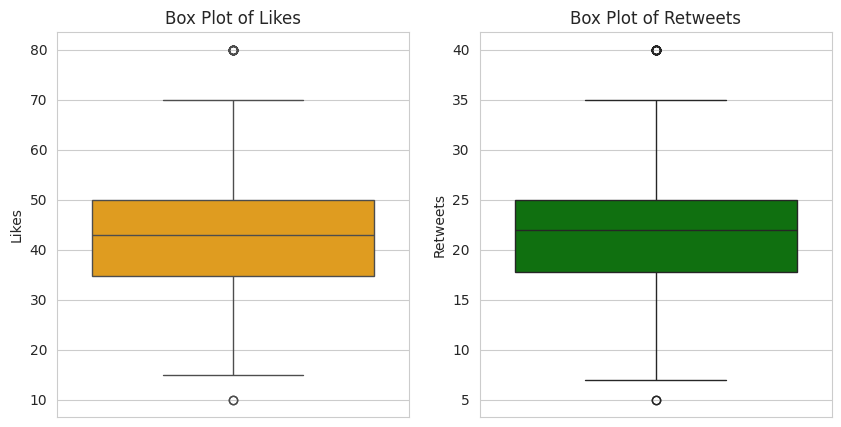

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


                                                Text  Sentiment  User  \
0   Enjoying a beautiful day at the park!        ...        214   645   
1   Traffic was terrible this morning.           ...        195   118   
2   Just finished an amazing workout! 💪          ...        214   226   
3   Excited about the upcoming weekend getaway!  ...        214     7   
4   Trying out a new recipe for dinner tonight.  ...        197    90   

   Platform                                    Hashtags  Retweets     Likes  \
0         3   #Nature #Park                             -0.922303 -0.916295   
1         3   #Traffic #Morning                         -2.339444 -2.336727   
2         1   #Fitness #Workout                         -0.213733 -0.206079   
3         0   #Travel #Adventure                        -1.914302 -1.981619   
4         1   #Cooking #Food                            -1.347445 -1.271403   

   Country      Year     Month       Day      Hour  \
0      106  0.902984 -1.502582 -

In [1]:

from google.colab import drive
drive.mount('/content/drive')

#Loading the dataset.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
df = pd.read_csv('/content/drive/My Drive/6dataset/two.csv')
print(df.columns)

# Set style for plots
sns.set_style("whitegrid")

# Define numerical columns for analysis
num_cols = ['Likes', 'Retweets', 'Year', 'Month', 'Day', 'Hour']

# --- Scatter Plot: Likes vs Retweets ---
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Likes'], y=df['Retweets'], alpha=0.5, color='blue')
plt.xlabel("Likes")
plt.ylabel("Retweets")
plt.title("Scatter Plot: Likes vs Retweets")
plt.show()

# --- Correlation Matrix ---
plt.figure(figsize=(8, 5))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# --- Histograms for Numerical Features ---
df[num_cols].hist(figsize=(10, 6), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

# --- Box Plot for Outlier Detection ---
plt.figure(figsize=(10, 5))

# Boxplot for Likes
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Likes'], color='orange')
plt.title("Box Plot of Likes")

# Boxplot for Retweets
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Retweets'], color='green')
plt.title("Box Plot of Retweets")

plt.show()


import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import nltk
nltk.download('punkt_tab')



# ---------------------- 2. Remove Unnecessary Columns ----------------------
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # Remove 'Unnamed' columns if present

# ---------------------- 3. Handle Timestamp ----------------------
df = df.copy()  # Ensure we work on a fresh copy

if "Timestamp" in df.columns:
    # Convert to datetime safely (handle errors)
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

    # Ensure only valid datetime values are processed
    valid_mask = df["Timestamp"].notna()  # Mask for valid timestamps

    if valid_mask.any():  # Only proceed if there are valid datetime values
        df.loc[valid_mask, "Year"] = df.loc[valid_mask, "Timestamp"].dt.year
        df.loc[valid_mask, "Month"] = df.loc[valid_mask, "Timestamp"].dt.month
        df.loc[valid_mask, "Day"] = df.loc[valid_mask, "Timestamp"].dt.day
        df.loc[valid_mask, "Hour"] = df.loc[valid_mask, "Timestamp"].dt.hour

    # Drop the original Timestamp column
    df.drop(columns=["Timestamp"], inplace=True)



# ---------------------- 4. Handle Numerical Data ----------------------
numeric_cols = ["Likes", "Retweets", "Year", "Month", "Day", "Hour"]
existing_numeric_cols = [col for col in numeric_cols if col in df.columns]

# Convert numerical columns to numeric type and fill missing values
for col in existing_numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())  # ✅ Fixed inplace warning

# Normalize numerical columns
scaler = StandardScaler()
df[existing_numeric_cols] = scaler.fit_transform(df[existing_numeric_cols])

# ---------------------- 5. Handle Categorical Data ----------------------
categorical_cols = ["Sentiment", "User", "Platform", "Country"]
label_encoders = {}  # Store encoders for consistency

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")  # Fill missing values
        label_encoders[col] = LabelEncoder()  # Create a label encoder for each column
        df[col] = label_encoders[col].fit_transform(df[col].astype(str))  # Apply encoding

# ---------------------- 6. Text Preprocessing ----------------------
# Download necessary NLTK resources
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to clean text
def preprocess_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www.\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtag symbols
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

# Apply text preprocessing
if "Text" in df.columns:
    df["Cleaned_Text"] = df["Text"].apply(preprocess_text)

# ---------------------- 7. Display Processed Data ----------------------
print(df.head())
print(df.columns)

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Ensure df exists
if "df" not in locals():
    raise NameError("Dataset 'df' is not defined. Load your dataset before running this script.")

# Ensure 'Cleaned_Text' column exists
if "Cleaned_Text" not in df.columns:
    raise KeyError("Column 'Cleaned_Text' not found in dataset!")

# Drop missing values
df = df.dropna(subset=["Cleaned_Text", "Sentiment"])

# ---------------------- 1. Adjust test_size ----------------------
num_classes = df["Sentiment"].nunique()
dataset_size = len(df)
test_size_ratio = max(0.2, num_classes / dataset_size)

# ---------------------- 2. Text Vectorization (TF-IDF) ----------------------
vectorizer = TfidfVectorizer(max_features=10000)
X_text = vectorizer.fit_transform(df["Cleaned_Text"])

# ---------------------- 3. Prepare Features ----------------------
numeric_cols = ["Likes", "Retweets", "Year", "Month", "Day", "Hour"]
missing_cols = [col for col in numeric_cols if col not in df.columns]
if missing_cols:
    raise KeyError(f"Missing numeric columns in dataset: {missing_cols}")

X_numeric = df[numeric_cols].values
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

X_final = np.hstack((X_numeric, X_text.toarray()))
y = df["Sentiment"]

# ---------------------- 4. Handle Imbalanced Data (SMOTE + RandomOverSampler) ----------------------
class_counts = df["Sentiment"].value_counts()
min_samples_per_class = class_counts.min()

if min_samples_per_class < 2:
    print("Warning: Some classes have only one sample. Using RandomOverSampler instead of SMOTE.")
    oversampler = RandomOverSampler(sampling_strategy="auto", random_state=42)
else:
    # Set k_neighbors to avoid errors
    smote_k = max(1, min(min_samples_per_class - 1, 5))
    oversampler = SMOTE(sampling_strategy="auto", k_neighbors=smote_k, random_state=42)

X_balanced, y_balanced = oversampler.fit_resample(X_final, y)

# ---------------------- 5. Train-Test Split ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=test_size_ratio, stratify=y_balanced, random_state=42
)

# ---------------------- 6. Train SVM Model (Using RBF Kernel for Better Accuracy) ----------------------
svm_model = SVC(kernel="rbf", C=1.5, gamma="scale", class_weight="balanced", random_state=42)
svm_model.fit(X_train, y_train)

# ---------------------- 7. Model Evaluation ----------------------
y_pred = svm_model.predict(X_test)

print(f"SVM Model Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Ensure 'Cleaned_Text' exists
if "Cleaned_Text" not in df.columns:
    raise KeyError("Column 'Cleaned_Text' not found in dataset!")

# Drop rows with missing values
df = df.dropna(subset=["Cleaned_Text", "Sentiment"])

# Remove extremely rare classes (<2 samples)
class_counts = df["Sentiment"].value_counts()
rare_classes = class_counts[class_counts < 2].index
df = df[~df["Sentiment"].isin(rare_classes)]

# ---------------------- 1. Feature Engineering ----------------------
text_features = df["Cleaned_Text"]
numeric_features = df[["Likes", "Retweets", "Year", "Month", "Day", "Hour"]]  # Numeric features
target = df["Sentiment"]

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words=None)
X_text = vectorizer.fit_transform(text_features)

# Scale numeric features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(numeric_features)

# Combine TF-IDF text features with numeric features
X_final = np.hstack((X_numeric, X_text.toarray()))

# ---------------------- 2. Handle Imbalanced Classes ----------------------
try:
    smote = SMOTE(random_state=42, k_neighbors=1)  # Use k=1 to avoid errors
    X_resampled, y_resampled = smote.fit_resample(X_final, target)
except ValueError:
    print("⚠️ SMOTE failed due to rare classes! Using RandomOverSampler instead.")
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_final, target)

# ---------------------- 3. Split Data ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# ---------------------- 4. Train Random Forest Model ----------------------
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)

# ---------------------- 5. Model Evaluation ----------------------
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"🔥 Random Forest Model Accuracy: {accuracy:.4f}")
print("🔹 Classification Report:\n", classification_rep)
print("🔹 Confusion Matrix:\n", conf_matrix)


In [2]:
# ====================== DIMENSIONALITY REDUCTION ======================
from sklearn.decomposition import PCA  # <-- THIS WAS MISSING
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
import numpy as np
print("\n=== Applying Dimensionality Reduction ===")

# Using PCA (as in your working version)
pca = PCA(n_components=0.98)  # Keep 95% variance
X_reduced = pca.fit_transform(X_final)
print(f"Reduced from {X_final.shape[1]} to {X_reduced.shape[1]} features")

# ====================== UPDATE PIPELINE WITH REDUCED FEATURES ======================
# Re-run resampling on reduced features
try:
    X_resampled, y_resampled = smote.fit_resample(X_reduced, target)
except:
    X_resampled, y_resampled = ros.fit_resample(X_reduced, target)

# Split the reduced data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)

# ====================== TRAIN MODEL ON REDUCED FEATURES ======================
print("\n=== Training Random Forest on Reduced Features ===")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1  # Enable parallel processing
)
rf_model.fit(X_train, y_train)

# ====================== EVALUATE PERFORMANCE ======================
y_pred = rf_model.predict(X_test)

print("\n=== Performance After Dimensionality Reduction ===")
print(f"🔥 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ====================== SAFE FEATURE IMPORTANCE ANALYSIS ======================
if hasattr(pca, 'components_'):
    print("\nTop contributing original features:")

    # For numeric features
    num_features = numeric_features.columns.tolist()
    if len(num_features) > 0:
        numeric_importance = np.abs(pca.components_[:, :len(num_features)]).mean(axis=0)
        print("Numeric features:")
        for idx in np.argsort(numeric_importance)[-5:]:  # Top 5 numeric
            if idx < len(num_features):
                print(f"- {num_features[idx]} (importance: {numeric_importance[idx]:.3f})")

    # For text features - only if vectorizer exists
    if 'vectorizer' in locals() and hasattr(vectorizer, 'get_feature_names_out'):
        text_feature_names = vectorizer.get_feature_names_out()
        text_comp_start = len(num_features)
        text_importance = np.abs(pca.components_[:, text_comp_start:]).mean(axis=0)

        print("\nTop text keywords:")
        # Get valid indices only
        valid_indices = [i for i in np.argsort(text_importance)[-5:] if i < len(text_feature_names)]
        for idx in valid_indices:
            print(f"- {text_feature_names[idx]} (importance: {text_importance[idx]:.3f})")


=== Applying Dimensionality Reduction ===
Reduced from 5623 to 425 features

=== Training Random Forest on Reduced Features ===

=== Performance After Dimensionality Reduction ===
🔥 Accuracy: 0.9492
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.89      0.94         9
           2       1.00      0.89      0.94         9
           4       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         8
           8       0.75      1.00      0.86         9
           9       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         9
          15       0.90      1.00      0.95         9
          16       0.89      1.00      0.94         8
          21       0.90      1.00      0.95         9
          22       1.00      1.00      1.00         8
          24     

In [3]:
#HYPERPARAMETER
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ====================== CHECK DATA CONSISTENCY ======================
print(f"Shape of X_resampled: {X_resampled.shape}")
print(f"Shape of y_resampled: {y_resampled.shape}")

# Reset index (in case y_resampled is a pandas series)
if hasattr(y_resampled, "reset_index"):
    y_resampled = y_resampled.reset_index(drop=True)

# Ensure consistency before train-test split
assert len(X_resampled) == len(y_resampled), "Mismatch in resampled data sizes!"

# Split the reduced data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)

# Use a smaller dataset for hyperparameter tuning
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.3, random_state=42)

# ====================== FAST HYPERPARAMETER TUNING USING HALVING RANDOM SEARCH ======================
print("\n=== Running HalvingRandomSearchCV for Fast Hyperparameter Tuning ===")

# Define hyperparameter search space
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20, 25, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

halving_search = HalvingRandomSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    factor=2,  # Reduces candidates by half each iteration
    min_resources=100,  # ✅ Fix: Set a reasonable number (e.g., 100)
    random_state=42,
    n_jobs=-1
)

# Fit on smaller dataset
halving_search.fit(X_sample, y_sample)

# Print best hyperparameters
print("\n=== Best Hyperparameters from HalvingRandomSearchCV ===")
print(halving_search.best_params_)

# ====================== TRAIN FINAL MODEL WITH BEST HYPERPARAMETERS ======================
print("\n=== Training Final Model with Best Hyperparameters ===")

best_params = halving_search.best_params_
final_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# ====================== EVALUATE FINAL MODEL ======================
y_pred = final_model.predict(X_test)

print("\n=== Final Model Performance ===")
print(f"🔥 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Shape of X_resampled: (5896, 425)
Shape of y_resampled: (5896,)

=== Running HalvingRandomSearchCV for Fast Hyperparameter Tuning ===

=== Best Hyperparameters from HalvingRandomSearchCV ===
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}

=== Training Final Model with Best Hyperparameters ===

=== Final Model Performance ===
🔥 Accuracy: 0.9805
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00         9
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         9
          15       1.00   

                                   Model Variation  Accuracy  Macro Avg  \
0  Random Forest (Before Dimensionality Reduction)      0.92       0.92   
1   Random Forest (After Dimensionality Reduction)      0.95       0.95   
2               Random Forest (After Optimization)      0.98       0.98   

   Weighted Avg  Performance Change  
0          0.92            0.000000  
1          0.94            3.260870  
2          0.98            3.157895  


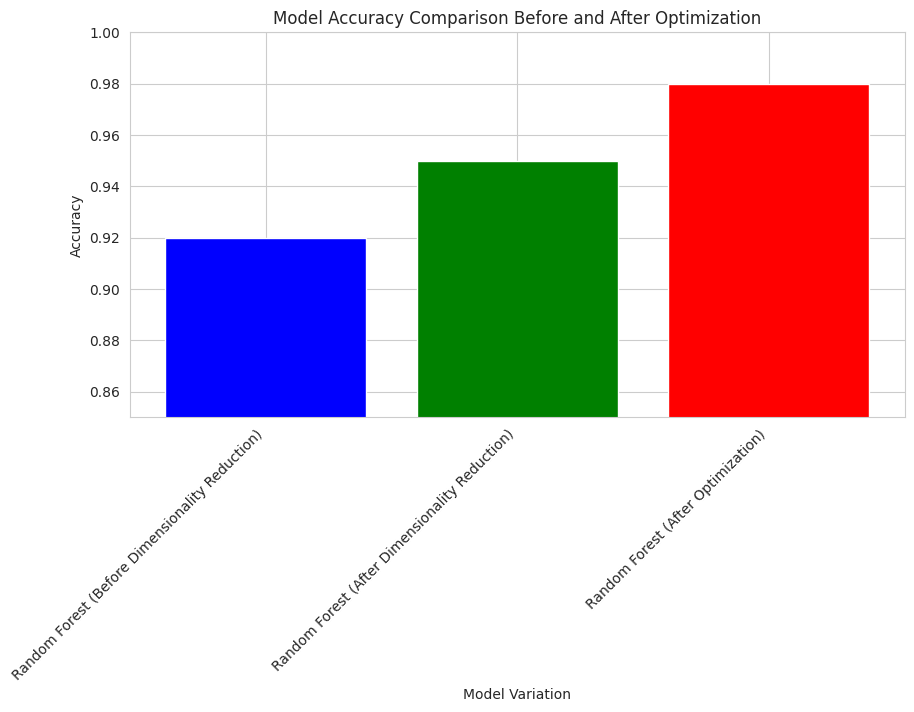

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating DataFrame with model performance
data = {
    "Model Variation": [


        "Random Forest (Before Dimensionality Reduction)",
        "Random Forest (After Dimensionality Reduction)",
        "Random Forest (After Optimization)"
    ],
    "Accuracy": [0.92, 0.95, 0.98],
    "Macro Avg": [0.92, 0.95, 0.98],
    "Weighted Avg": [0.92, 0.94, 0.98]
}

df = pd.DataFrame(data)

# Performance change calculation
df["Performance Change"] = df["Accuracy"].pct_change().fillna(0) * 100

# Print the DataFrame
print(df)

# Plot the accuracy comparison
plt.figure(figsize=(10, 5))
plt.bar(df["Model Variation"], df["Accuracy"], color=['blue', 'green', 'red', 'orange', 'purple'])
plt.xlabel("Model Variation")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison Before and After Optimization")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.85, 1)
plt.show()


In [6]:
from sklearn.ensemble import BaggingClassifier

# Create a Bagging ensemble of optimized Random Forest models
bagging_clf = BaggingClassifier(estimator=rf_model, n_estimators=10, random_state=42, n_jobs=-1)

# Train the ensemble model
bagging_clf.fit(X_train, y_train)

# Model Evaluation
y_pred_bagging = bagging_clf.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)

print("Bagging Classifier Accuracy:", accuracy_bagging)


Bagging Classifier Accuracy: 0.9796610169491525


In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Base estimator: use a weak learner (e.g., decision stump)
base_estimator = DecisionTreeClassifier(max_depth=1)

# Create the AdaBoost ensemble
adaboost_clf = AdaBoostClassifier(
    estimator=rf_model,  # You can also use `base_estimator=...` in older versions
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

# Train the AdaBoost model
adaboost_clf.fit(X_train, y_train)

# Model Evaluation
y_pred_adaboost = adaboost_clf.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)

print("AdaBoost Classifier Accuracy:", accuracy_adaboost)


AdaBoost Classifier Accuracy: 0.9838983050847457


In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode y values to 0 to n_classes - 1
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Now use XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='mlogloss',  # For multi-class
    random_state=42
)

xgb_clf.fit(X_train, y_train_enc)
y_pred_xgb = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_test_enc, y_pred_xgb)

print("XGBoost Accuracy:", accuracy)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:18:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9847457627118644
